# **Conception d'une application au service de la santé publique**
*Sofia Chevrolat (Juin 2020)*
___
Cette étude en deux notebooks vise à estimer la faisabilité d'exploiter la base de données de  l’organisme <i>“Open Food Facts”</i>, contenant des informations sur plus d'1 millions d'aliments, dans le cadre d'un appel à projets par Santé publique France. 
Agence nationale de santé publique en France, Santé publique France souhaite trouver des idées innovantes d’applications en lien avec l'alimentation. 

Compte tenu du focus de l'appel à projet, cette pré-analyse se focalisera sur trois points :
- **Les catégories des aliments** : leur groupe et sous-groupe PNNS, ainsi que leur groupe NOVA.
- **Les valeurs nutritionnelles des aliments** : en particulier les grands groupes nutritionnels (protéines, lipides et carbohydrates)

L'étude portant sur une application pour Santé Publique France, nous prendrons pour référence les produits vendus en France. 
___
_**Remerciements**:<br>
Merci à mon compagnon [J. Duplan](https://www.linkedin.com/in/julian-duplan-64844a41/) pour les discussions intéressantes.<br>
Merci également à mon mentor [Samia Drappeau](https://www.linkedin.com/in/samiadrappeau) pour les échanges d'idées, les conseils sur les graphiques et les encouragements!_
___

Cette étude est organisée en 2 notebooks: 
- Notebook de nettoyage
- Notebook d'analyse

___
## Notebook 1 : Nettoyage des données

Ce notebook est organisé comme suit:

**0. Mise en place**
- 0.1 Chargement des librairies nécessaires
- 0.2 Définition des fonctions utiles
- 0.3 Chargement du jeu de données
- 0.4 Description du jeu de données

**1. Ciblage des données**
- 1.1 Restriction aux produits vendus en France
- 1.2 Sélection des colonnes
- 1.3 Séparation du jeu de données produits alcoolisés / non alcoolisés

**2. Nettoyage**
- 2.1 Suppression des colonnes et lignes entièrement vides    
- 2.2 Traitement des doublons
    * 1.2.1 Au niveau des lignes
    * 1.2.2 Au niveau des colonnes
- 2.3 Traitement des valeurs NaN
    * 1.5.1 Au sein des variables qualitatives
    * 1.5.2 Au sein des variables quantitatives
- 2.4 Traitement des outliers

**3. Export des données nettoyées**
- 2.1 Export des données des produits non-alcoolisés
- 2.2 Export des données des produits alcoolisés

**4. Annexes**

___
### 0. MISE EN PLACE

Dans cette première étape, le cadre de travail est mis en place, c'est-à-dire :
- Les librairies et packages Python nécessaires sont chargés
- Les fonctions utiles sont définies
- Le jeu de données est chargé
___

___
#### 0.1 CHARGEMENT DES LIBRAIRIES NÉCESSAIRES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

___
#### 0.2 CHARGEMENT DES FONCTIONS UTILES
Ces fonctions ont été écrites dans le cadre de cette étude afin d'automatiser certaines étapes des traitements et visualisations mises en œuvre.

In [2]:
import helper_functions as hf

**_N.B : Le code de ces fonctions est également disponible en fin de notebook, section "Annexes"_**
___
#### 0.3 CHARGEMENT DU JEU DE DONNÉES

Les données sont disponibles sur un serveur distant, et non en téléchargement direct.
Le chargement des données procèdera donc de la façon suivante :
- Au tout premier lancement du notebook, récupérer les données via le lien proposé, puis les sauvegarder dans un fichier .csv local.
- Par la suite, les données seront lues directement depuis le fichier local.

_**N.B : Penser à rafraîchir les données en relançant leur récupération depuis le serveur pour disposer des dernières données en date**_

In [3]:
# Fetching the data via the link provided - very time consuming operation

#pd.read_csv('https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv',
                        #sep='\t', low_memory=False).to_csv("open_food_facts_df.csv")

In [4]:
# Fetching the data from the local file - added for convenience

food_data = pd.read_csv("open_food_facts_df.csv", low_memory=False)

In [5]:
# Removing additionnal index column

food_data = food_data.iloc[:,1:]

____
#### 0.4 DESCRIPTION DU JEU DE DONNÉES

In [6]:
# Brief description of the dataframe containing the data

hf.descriptionJeuDeDonnees({'Food Data':[food_data, "Données Food"]})

Les données se décomposent en 1 fichier(s): 



,Nom du fichier,Nb de lignes,Nb de colonnes,Description
1,Food Data,1321737,167,Données Food


___
### 1. CIBLAGE DES DONNÉES

___
#### 1.1 RESTRICTION AUX PRODUITS VENDUS EN FRANCE

Comme indiqué dans l'introduction, il s'agit ici d'un appel à projet lancé par Santé publique France. <br>
Les données pertinentes sont donc uniquement celles concernant les aliments vendus en France, c'est donc à celles-ci que nous allons nous restreindre.

In [8]:
# Considering products sold in France only
data = food_data[food_data["countries_tags"].str.contains('france', regex=True)==True]

___
#### 1.2 SÉLECTION DES COLONNES

___
##### _<u>1.2.1 Suppression des colonnes non exploitables dans le cadre de cette analyse</u>_

Les colonnes contenant des informations de gestion des données de la table ne sont pas pertinentes à l'analyse. <br>
Elles sont donc supprimées.

In [9]:
# Removing columns that are not relevant to an analysis

data = data.drop(columns=['created_datetime', 'created_t', 'url', 'last_modified_t',
                          'creator','last_modified_datetime', 'image_url', 
                          'image_small_url','image_ingredients_small_url', 
                          'image_ingredients_url', 'image_nutrition_url', 
                          'image_nutrition_small_url'])

##### _<u>1.2.2 Visualisation du taux de remplissage par colonne</u>_

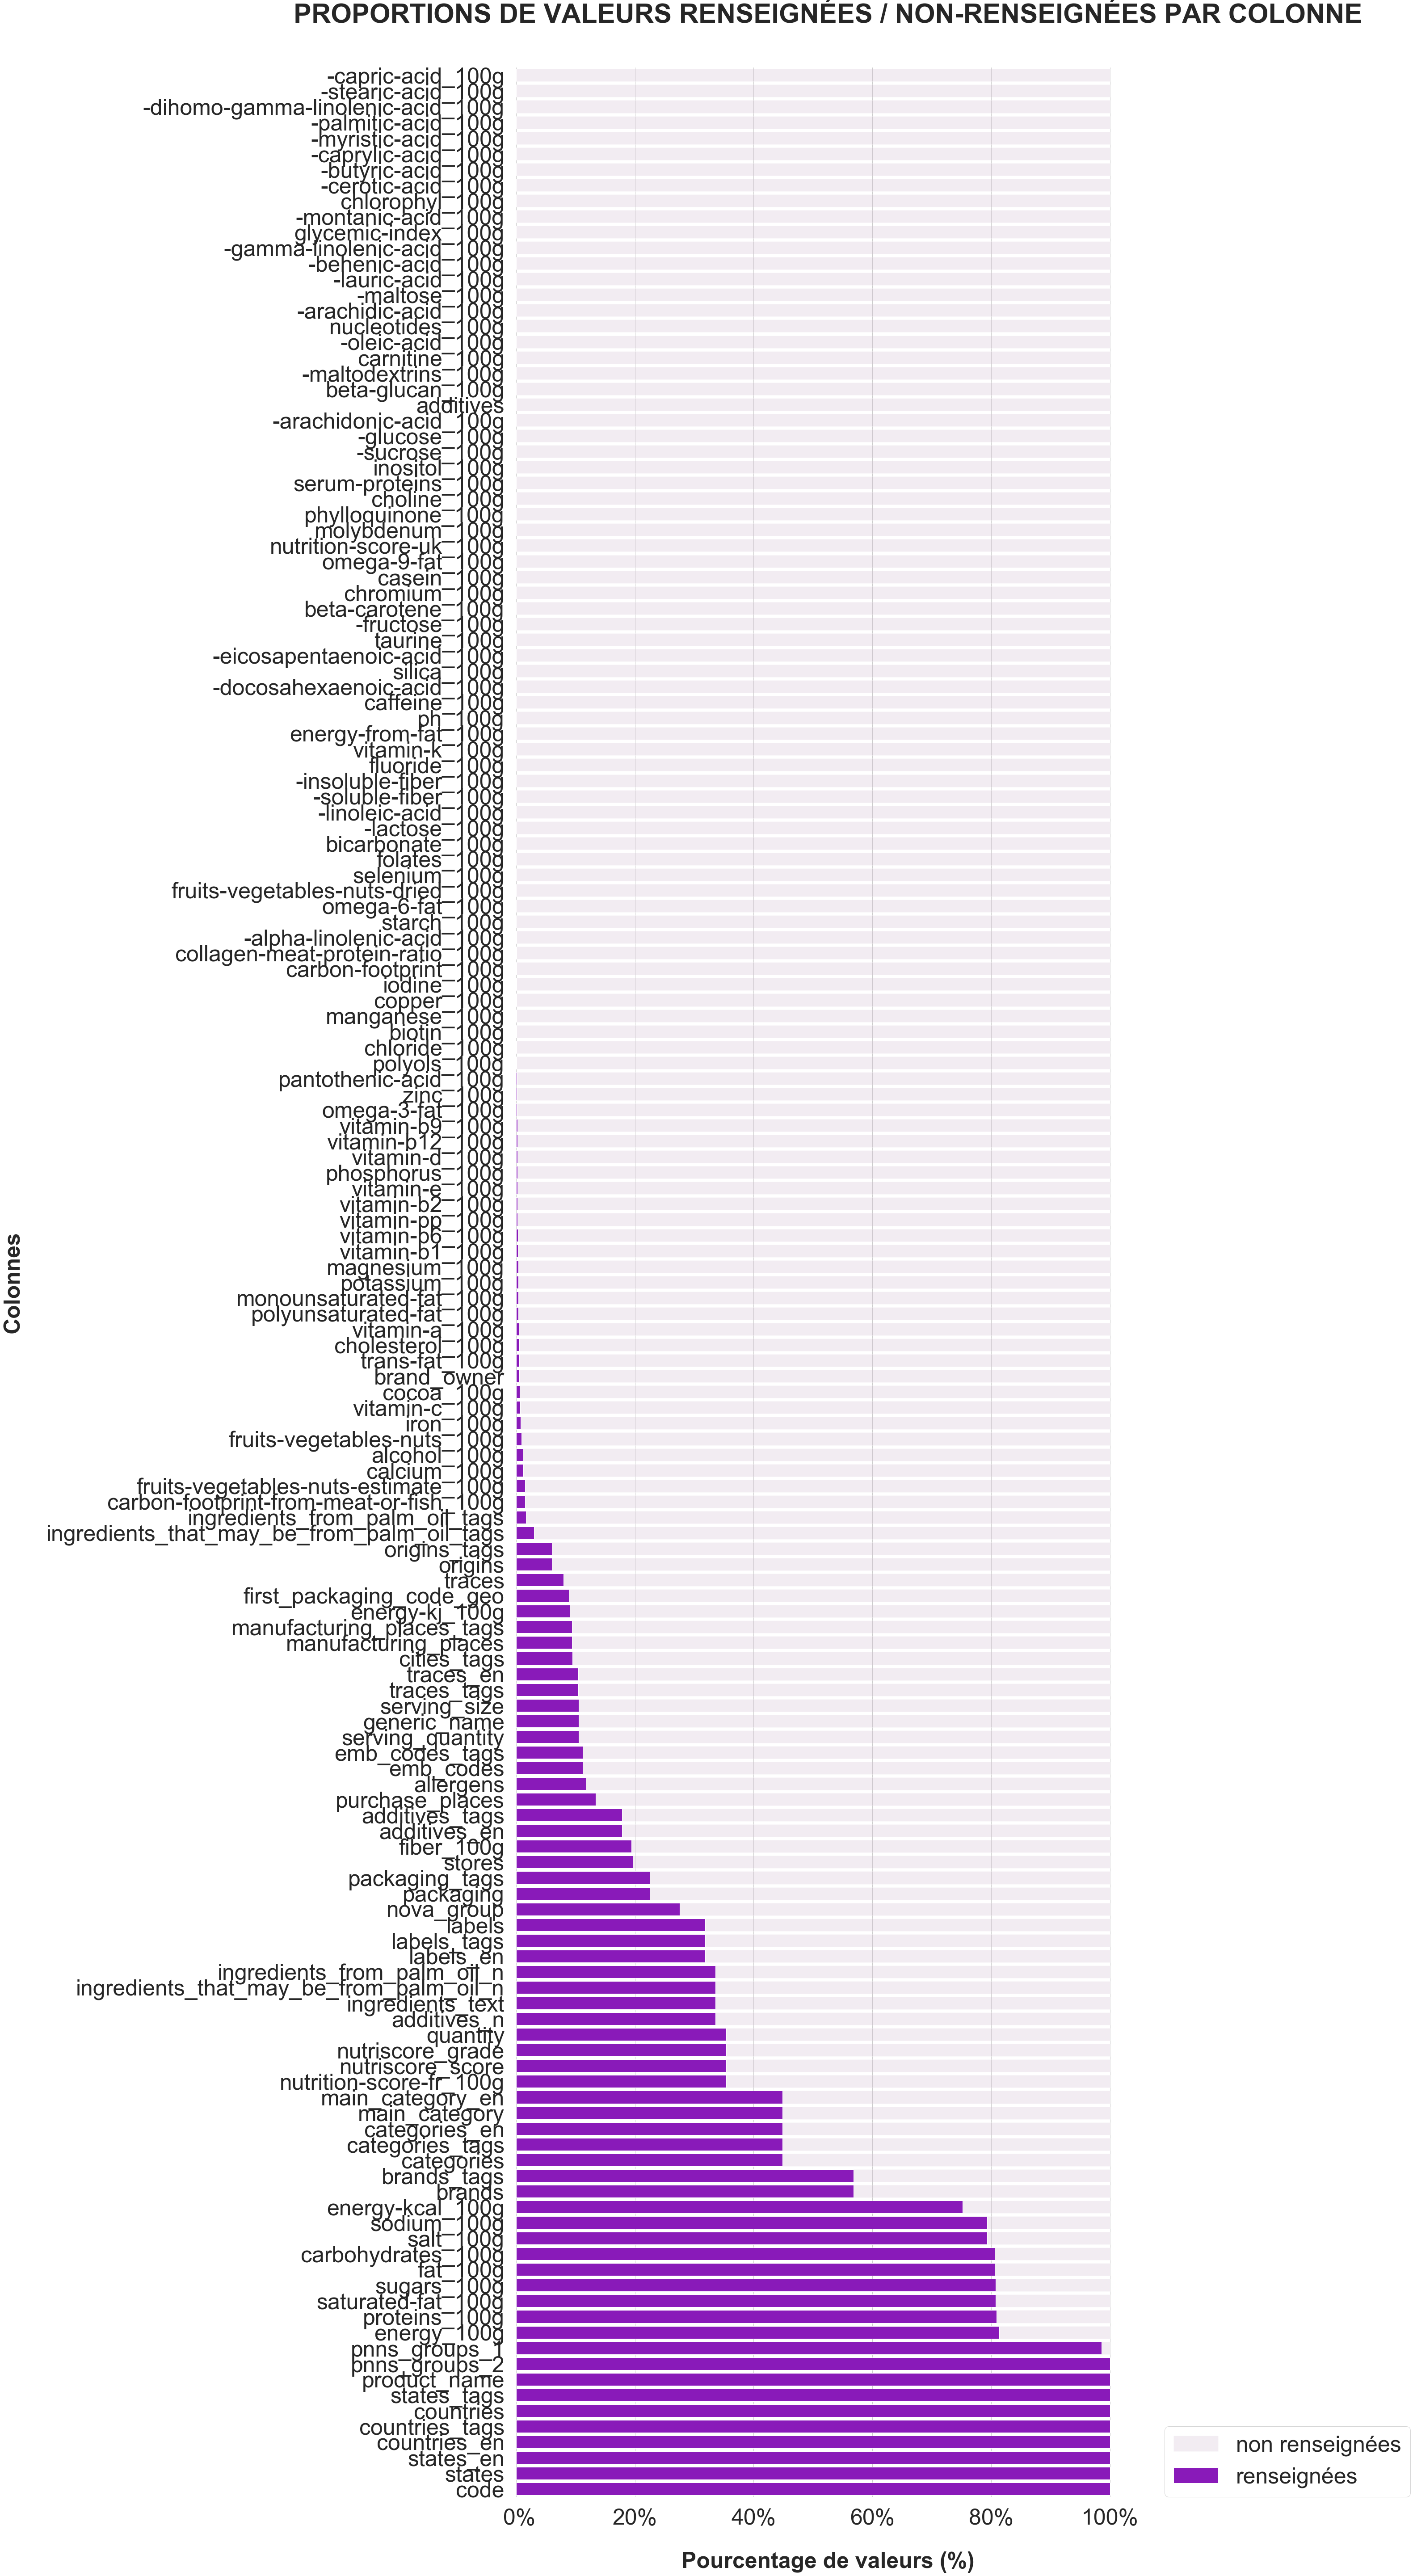

In [10]:
# Visualising filling rates for each column
hf.plotPercentageMissingValuesFor(data, 25, 100)

Un grand nombre de colonnes semblent contenir très peu de données (taux de remplissage < 40%).

##### _<u>1.2.2 Restriction aux colonnes ayant les taux de remplissage les plus importants</u>_

Afin d'avoir un jeu de données aussi qualitatif que possible, les colonnes considérées vont être restreintes 
à celles dont le taux de données non renseignées se situe dans le 1er quartile de la distribution.

In [11]:
# Keep only the first quartile.

missing_percent_df = hf.getMissingValuesPercentPer(data)

bins = 4  # Bin into quartiles.
selected_data = missing_percent_df[pd.qcut(missing_percent_df['Percent Missing'], 
                                            bins, labels=range(bins)).eq(0)].index.tolist()

data_selected = data[selected_data]

___
##### _<u>1.2.3 Suppression des colonnes non pertinentes dans le cadre de cette analyse</u>_

L'analyse a prévu de se concentrer sur les groupes alimentaires (PNNS et NOVA) ainsi que sur les valeurs nutritionnelles.
Les colonnes n'appartenant pas à ces 2 groupes sont donc supprimées.

In [12]:
# Removing columns that are not relevant to an analysis

data_selected = data_selected.drop(columns=['quantity', 'packaging', 'brands', 'brands_tags',
                                            'countries','countries_tags', 'countries_en', 
                                            'ingredients_text','ingredients_from_palm_oil_n', 
                                            'ingredients_that_may_be_from_palm_oil_n'])

#### 1.3 SÉPARATION DU JEU DE DONNÉES PRODUITS ALCOOLISÉS / PRODUITS NON ALCOOLISÉS

Le guide du nutriscore indique que les producteurs de boissons dont la teneur en alcool est supérieure à 1.2% n'étant pas tenus de déclarer les valeurs nutritionnelles de leurs produits, ceux-ci ne sont pas concernés par le nutriscore.<br>

L'information de la teneur en alcool qui aurait permis de filtrer sur le caractère inférieur ou non à 1.2% n'étant pas présente dans le jeu de données, celui-ci sera simplement séparé en 2:
- les données concernant les produits non alcoolisés
- les données concernant les produits alcoolisés

In [13]:
# Séparation des dataframes entre alcool et nutriscore 
data_alcohol = data_selected[data_selected["pnns_groups_2"]=="Alcoholic beverages"]\
                .drop(columns=["pnns_groups_1", "pnns_groups_2"])

data_nutriscore = data_selected[data_selected["pnns_groups_2"]!="Alcoholic beverages"]\
                  .drop(columns="product_name")

___
### 1. NETTOYAGE

___
#### 1.1 SUPPRESSION DES COLONNES ET LIGNES ENTIÈREMENT VIDES

In [14]:
# Dropping all columns and rows that are entirely empty

data_nutriscore = data_nutriscore.dropna(how='all').dropna(how='all', axis=1)
data_alcohol = data_alcohol.dropna(how='all').dropna(how='all', axis=1)

___
#### 1.2 TRAITEMENT DES DOUBLONS

##### <u>1.2.1 Au niveau des lignes</u>

- Certaines lignes représentent le même aliment (colonne "code" contenant une valeur identique).<br>
Une simple suppression des lignes en doublon représenterait une perte d'informations. <br>
Pour éviter cela, une "fusion" des données est effectuée, en remplaçant les valeurs NaN de la première ligne par celles de la 2ème ligne.

In [15]:
# Treating doublons - rows 

data_nutriscore = hf.fuseDoublonRows(data_nutriscore, "code").drop(columns=["code"])
data_alcohol = hf.fuseDoublonRows(data_alcohol, "code").drop(columns=["code"])

- Certaines lignes contiennent des valeurs de groupes PNNS mal ou différemment orthographiées. Il convient donc d'harmoniser les différentes orthographes des valeurs acceptées pour les groupes PNNS. <br>
**N.B : Le jeu de données data_alcohol n'est pas concerné par cette opération, les groupes PNNS couverts n'y étant par définition pas représentés.**

In [16]:
# Treating doublons categories - pnns

# pnns_groups_1
pnns_groups_1 = {"fruits-and-vegetables":"Fruits and vegetables",
                 "sugary-snacks":"Sugary snacks",
                 "salty-snacks": "Salty snacks",
                 "cereals-and-potatoes":"Cereals and potatoes"}

hf.replaceValues(data_nutriscore, "pnns_groups_1", pnns_groups_1)


# pnns_groups_2    
pnns_groups_2 = {"Pizza pies and quiche":"Pizza pies and quiches",
                 "vegetables":"Vegetables",
                 "nuts":"Nuts",
                 "legumes":"Legumes",
                 "fruits":"Fruits",
                 "cereals":"Cereals"}

hf.replaceValues(data_nutriscore, "pnns_groups_2", pnns_groups_2)

##### <u>1.2.2 Au niveau des colonnes</u>

Certaines colonnes contiennent les mêmes valeurs que d'autres colonnes (<i>"energy-kcal_100"</i> et <i>"energy_100g"</i>, <i>"nutriscore-score-fr_100g"</i> et <i>"nutriscore_score"</i>), parfois sous un format différent (<i>"brands"</i> et <i>"brands-tags"</i>).<br>

**Exemple** : La colonne <i>"sodium_100g"</i> peut être calculée directement à partir de la colonne <i>"salt_100g"</i>: 
>sodium_100g = salt_100g / 2.5. 

Il n'est donc pas nécessaire de conserver les deux colonnes.

In [17]:
# Removing columns that are doublons of other columns

data_nutriscore = data_nutriscore.drop(columns=['energy-kcal_100g', 'sodium_100g', 'nutrition-score-fr_100g', 
                                                'categories','categories_en','states', 'states_en',
                                                'main_category_en'])

data_alcohol = data_alcohol.drop(columns=['energy-kcal_100g', 'sodium_100g', 'nutrition-score-fr_100g', 
                                           'categories','categories_en','states', 'states_en',
                                           'main_category_en'])

___
#### 1.6 TRAITEMENT DES VALEURS NAN

##### _<u> 1.6.1 Au sein des variables quantitatives</u>_

Pour remplacer les valeurs manquantes, on va procéder en 2 étapes:
  1. Grouper les données par valeur de groupe PNNS 2
  2. Pour chaque groupe PNNS 2, remplacer les valeurs NaN de la colonne concernée par la valeur **moyenne** de ce groupe sur l'échantillon (groupe PNNS 2)
  
Cette façon de procéder donnera de meilleurs résultats que d'utiliser simplement la valeur moyenne sur l'ensemble du jeu de données.

_**N.B : Pour améliorer encore cette technique, l'utilisation de la moyenne dite "bootstrap" a été envisagée et testée, mais la demande en puissance de calcul s'est montré prohibitive.**_

In [18]:
############################################################
# TEST MEAN BOOTSTRAP MAIS PREND ÉNORMÉMENT DE TEMPS
############################################################

# Pour les variables quantitatives (except nutriscore_score), 
# remplacer par la valeur mean en groupant par groupe pnn2

#quantitative_columns = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
#                       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
#                       'salt_100g']

#for column in quantitative_columns:
    
#    for val_pnns_2, data_df in data_nutriscore.groupby(["pnns_groups_2"]):
#        print(column)
#        print("mean = ", data_df[column].mean())
#        print("mean bootstrap = ", hf.getBootstrapMean(data_df[column].reset_index(drop=True), 10000))

In [19]:
# Pour les variables quantitatives (except nutriscore_score), 
# remplacer par la valeur mean en groupant par groupe pnn2

quantitative_columns = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
                       'carbohydrates_100g', 'sugars_100g', 'proteins_100g',
                       'salt_100g']


hf.replaceNaNQuantitative(data_nutriscore, quantitative_columns, "pnns_groups_2")

In [20]:
# For alcohol, grouping by value of pnns_groups_2 would not be useful, 
# since it is the same for all rows

quantitative_columns = ['energy_100g', 'fat_100g', 'saturated-fat_100g',
                       'carbohydrates_100g', 'sugars_100g', 'proteins_100g',
                       'salt_100g']


hf.replaceNaNQuantitative(data_alcohol, quantitative_columns)

##### _<u>1.6.1 Au sein des variables qualitatives</u>_

On procèdera ici de façon similaire aux valeurs quantitatives, en utilisant la valeur **modale** pour la colonne pour chaque groupe PNNS 2.

In [21]:
# Pour les variables qualitatives (except nutriscore_grade)
# remplacer par la valeur modale en groupant sur pnns_groups_2

qualitative_columns = ["pnns_groups_1", "nova_group"]

hf.replaceNaNQualitative(data_nutriscore, qualitative_columns, "pnns_groups_2")

In [22]:
# For alcohol, grouping by value of pnns_groups_2 would not be useful, 
# since it is the same for all rows

qualitative_columns = ["nova_group"]

hf.replaceNaNQualitative(data_alcohol, qualitative_columns)

In [23]:
# Suppression des colonnes où les valeurs des groupes pnns_1 et pnns_2 sont
# "unknown".Il suffira d'appliquer la condition sur pnns_1 car de par les 
# traitements appliqués précédemment, si la valeur de pnns_groups_1 est 
# "unknown", celle de pnns_2 également.

# Uniquement nécessaire pour les données des produits non alcoolisés.

data_nutriscore = data_nutriscore[(data_nutriscore["pnns_groups_1"]!="unknown") \
                                  & \
                                  (data_nutriscore["pnns_groups_1"].notna())]

___
#### 1.7 TRAITEMENT DES VALEURS ABERRANTES

Les valeurs abherrantes ou outliers sont les valeurs situées à plus de 1,5 x Écart interquartile de la borne inférieure Q1 ou de la borne supérieure Q3.<br>

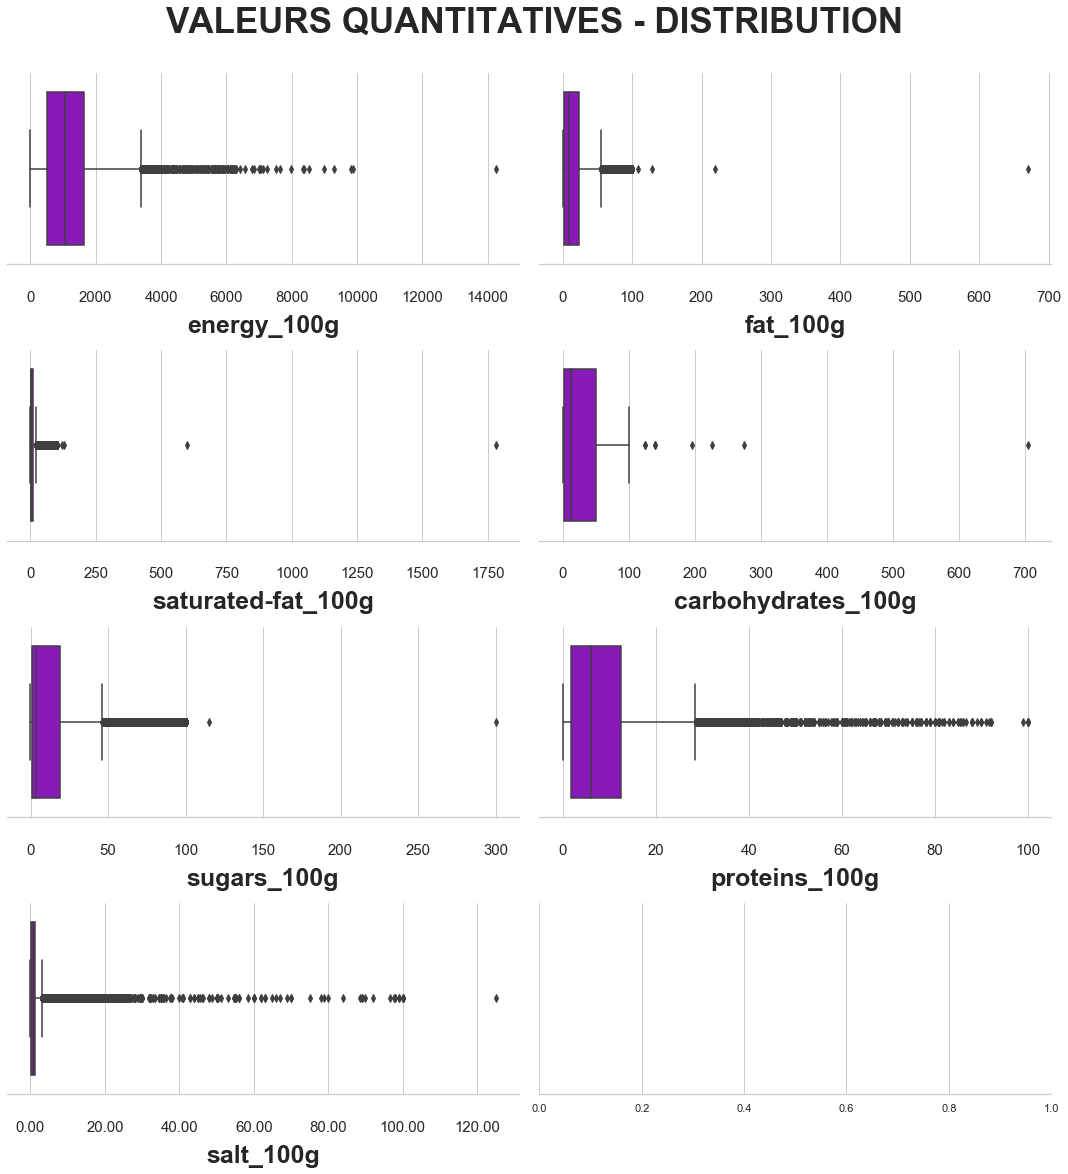

In [24]:
data_quants = data_nutriscore[data_nutriscore.columns.intersection(quantitative_columns)]

hf.plotBoxPlots(data_quants, 15, 15, 4, 2)

En affichant la boîte à moustache pour les valeurs qualitatives, on constate que ces dernières contiennent un certain nombre de valeurs aberrantes.<br>
On va donc les supprimer.

In [26]:
# for each column, remove the outlier values
filtered_nutriscore = data_nutriscore.copy().rename(columns={'saturated-fat_100g':'saturated_fat_100g'})

filtered_nutriscore = hf.removeOutlierValues(filtered_nutriscore, data_quants)
    
filtered_nutriscore = filtered_nutriscore.rename(columns={'saturated_fat_100g': 'saturated-fat_100g'})

In [27]:
# for each column, remove the outlier values
filtered_alcohol = data_alcohol.copy().rename(columns={'saturated-fat_100g':'saturated_fat_100g'})

filtered_alcohol = hf.removeOutlierValues(filtered_alcohol, data_quants)

filtered_alcohol = filtered_alcohol.rename(columns={'saturated_fat_100g': 'saturated-fat_100g'})

___
### 2. Export des données nettoyées

Les deux jeux de données sont exportés pour être ensuite analysés.

#### 2.1 EXPORT DES DONNÉES DES PRODUITS NON-ALCOOLISÉS

In [28]:
# Non-alcoholic products
filtered_nutriscore.to_csv('data_nutriscore_clean.csv')

#### 2.2 EXPORT DES DONNÉES DES PRODUITS ALCOOLISÉS 

In [29]:
# Alcohol products
filtered_alcohol.to_csv('data_alcohol_clean.csv')

___
### 3. Annexes

In [30]:
##########################################
#                                        #
# Fonctions de calcul et de descriptions #
#                                        #
##########################################

def getMissingValuesPercentPer(data):
    ''' 
        Calculates the mean percentage of missing values
        in a given pandas dataframe per unique value 
        of a given column
        
        Parameters
        ----------------
        data   : pandas dataframe
                 The dataframe to be analyzed
        
        Returns
        ---------------
        A pandas dataframe containing:
            - a column "column"
            - a column "Percent Missing" containing the percentage of 
              missing value for each value of column     
    '''
    
    missing_percent_df = pd.DataFrame({'Percent Missing':data.isnull().sum()/len(data)*100})

    missing_percent_df['Percent Filled'] = 100 - missing_percent_df['Percent Missing']

    missing_percent_df['Total'] = 100

    percent_missing = data.isnull().sum() * 100 / len(data.columns)
    
    return missing_percent_df


#------------------------------------------

def descriptionJeuDeDonnees(sourceFiles):
    ''' 
        Outputs a presentation pandas dataframe for the dataset.
        
        Parameters
        ----------------
        A dictionary with:
        - keys : the names of the files
        - values : a list containing two values : 
            - the dataframe for the data
            - a brief description of the file
        
        Returns
        ---------------
        A pandas dataframe containing:
            - a column "Nom du fichier" : the name of the file
            - a column "Nb de lignes"   : the number of rows per file 
            - a column "Nb de colonnes" : the number of columns per file
            - a column "Description"    : a brief description of the file     
    '''

    print("Les données se décomposent en {} fichier(s): \n".format(len(sourceFiles)))

    filenames = []
    files_nb_lines = []
    files_nb_columns = []
    files_descriptions = []

    for filename, file_data in sourceFiles.items():
        filenames.append(filename)
        files_nb_lines.append(len(file_data[0]))
        files_nb_columns.append(len(file_data[0].columns))
        files_descriptions.append(file_data[1])

        
    # Create a dataframe for presentation purposes
    presentation_df = pd.DataFrame({'Nom du fichier':filenames, 
                                    'Nb de lignes':files_nb_lines, 
                                    'Nb de colonnes':files_nb_columns, 
                                    'Description': files_descriptions})

    presentation_df.index += 1

    
    return presentation_df

#------------------------------------------

def getBootstrapMean(X, numberb):
    '''
        Calculate the bootstrap mean for a column
        Source : Introduction to Data Science,
        
        Parameters
        ----------------
        - X       : the data series to calculate the
                    bootstrap mean on
        - numberb : the number of samplings to perform
        
        Returns
        ---------------
        The bootstrap men of the column
    '''
    
    x = [0] * numberb
    
    for i in range(numberb):
        sample = [X[j]
                  for j
                  in np.random.randint(len(X), size=len(X))
                 ]
        x[i] = np.mean(sample)
    return mean(x)
    
#------------------------------------------

#------------------------------------------
# WARNING : only works if 2 doublons
# TODO : Systemize function below to work 
#        for 3 or more doublons
#------------------------------------------

def fuseDoublonRows(data, criteria_doublon):
    '''
        Returns a dataframe containing one fused row
        instead of two doublons rows for each couple of doublons
        
        ----------------
        - data             : DataFrame containing doublon rows
        - criteria_doublon : the name of the column to determine if
                             two rows are doublons
        
        Returns
        ---------------
        The dataframe with the fused rows, without the doublons
    '''
    
    duplicates = data[data[criteria_doublon].duplicated()][criteria_doublon]
    data_duplicates = data[data[criteria_doublon].isin(duplicates)]

    #-----------------------------------------------------------------
    # Merging the data from the doublons :
    # the new row becomes the first one, with its NaN values replaced
    # by the non NaN values of the second row
    #-----------------------------------------------------------------

    merged_duplicates = pd.DataFrame()

    for criteria_duplicate in duplicates:
        tmp_df = data_duplicates[data_duplicates[criteria_doublon]==criteria_duplicate]

        obj_df = tmp_df.select_dtypes(include=[np.object])
        num_df = tmp_df.select_dtypes(exclude=[np.object])

        merged_row = pd.concat([obj_df.head(1).fillna(obj_df.tail(1)).reset_index(drop=True),
                                num_df.max().to_frame().T.reset_index(drop=True)], axis=1)

        merged_duplicates = pd.concat([merged_duplicates, merged_row])

    #-----------------------------------------------------------------
    # Creating a new dataframe without the doublons, but with the
    # newly merged rows
    #-----------------------------------------------------------------

    return pd.concat([data[~data[criteria_doublon].isin(duplicates)],
                            merged_duplicates])
     
#------------------------------------------

def replaceValues(data, column, values):
    '''
        Replaces in place the given values by the given replacement
        values in a column of a dataframe
        
        ----------------
        - data   : DataFrame containing the values to
                   replace
        - column : The name of the column containing the values
                    to replace
        - values : A dictionary containing the values to replace
                   as keys, and the replacement values as values
        
        Returns
        ---------------
        _
    '''
    
    for value_error, value_correct in values.items():
        data.loc[data[column] == value_error, column] = value_correct
        
#------------------------------------------

def replaceNaNValues(data, cols, criterion, valueType):
    '''
        Replaces in place the NaN values in the list of columns given
        grouped by criterion if given, by the mode or the mean
        depending on the valueType given ("QUAL" or "QUANT")
        
        ----------------
        - data      : DataFrame containing the NaN values
        - cols      : A list containing the names of the columns in which
                      to replace the NaN values
        - criterion : The name of the column to groupby on for the calculation
                      of the mean
        - valueType : The type of values contained in the columns listed in
                      "cols" : "QUAL" or "QUANT"
        
        Returns
        ---------------
        _
    '''
    
    for column in cols:
        if criterion != None:
            value_per_criterion = {}

            for val_criterion, data_df in data.groupby([criterion]):
                if valueType == "QUAL":
                    value_per_criterion[val_criterion] = data_df[column].mode()[0]
                elif valueType == "QUANT":
                    value_per_criterion[val_criterion] = data_df[column].mean()

            for criterion_value, value in value_per_criterion.items():
                data.loc[data[criterion] == criterion_value, column] \
                = \
                data.loc[data[criterion] == criterion_value, column].fillna(value)
        else:
            if valueType == "QUAL":
                value = data[column].mode()[0]
            elif valueType == "QUANT":
                value = data[column].mean()
            else:
                raise Exception("Invalid value type :" + valueType)

            data[column] = data.loc[:, column].fillna(value)
    
#------------------------------------------

def replaceNaNQualitative(data, qualitative_cols, criterion=None):
    '''
        ** ONLY FOR COLUMNS CONTAINING QUALITATIVE INFO **
        
        Replaces in place the NaN values in the list of columns given
        by the mean of the column, grouped by criterion if given
        
        ----------------
        - data             : DataFrame containing the NaN values
        - qualitative_cols : A list containing the names of the
                             columns in which to replace the NaN
                             values
        - criterion        : The name of the column to groupby on for the
                             calculation of the mean
        
        Returns
        ---------------
        _
    '''
    
    replaceNaNValues(data, qualitative_cols, criterion, "QUAL")

#------------------------------------------

def replaceNaNQuantitative(data, quantitative_cols, criterion=None):
    '''
        ** ONLY FOR COLUMNS CONTAINING QUANTITATIVE INFO **
        
        Replaces in place the NaN values in the list of columns given
        by the mode of the column, grouped by criterion if given
        
        ----------------
        - data              : DataFrame containing the NaN values
        - quantitative_cols : A list containing the names of the
                              columns in which to replace the NaN
                              values
        - criterion         : The name of the column to groupby on for the
                              calculation of the mode
        
        Returns
        ---------------
        _
    '''
    
    replaceNaNValues(data, quantitative_cols, criterion, "QUANT")
              
#------------------------------------------

def removeOutlierValues(data, quantitative_columns, criterion=None):
    '''
        Removes the outliers in the given dataframe, grouped by criterion
        if given, in the given columns containing quantitative data
        
        ----------------
        - data                : The dataframe from which outliers need to
                                be removed
        - qualitative_columns : A list containing the names of the
                                columns in which to replace the NaN
                                values
        - criterion            : The name of the column to groupby and
                                 determine the outliers on
        
        Returns
        ---------------
        _ filtered_df : the dataframe without the outliers
    '''
    
    filtered_df = data.copy()

    if criterion != None:
        ## TODO : IMPLEMENT
        #for criterion_value, data_criterion in filtered_df.groupby([criterion]):
        print("TO IMPLEMENT")
        
    else:
        for column in quantitative_columns:
            Q1 = filtered_df[column].quantile(0.25)
            Q3 = filtered_df[column].quantile(0.75)
            IQR = Q3 - Q1
            
            # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
            filtered_df = filtered_df.query('(@Q1 - 1.5 * @IQR) <= '+ str(column) +' <= (@Q3 + 1.5 * @IQR)')
          
    return filtered_df


    
##########################################
#                                        #
# Fonctions de graphiques                #
#                                        #
##########################################

def plotPercentageMissingValuesFor(data, long, larg):
    ''' 
        Plots the proportions of filled / missing values for each unique value
        in column as a horizontal bar chart.
        
        Parameters
        ----------------
        data : pandas dataframe with:
                - a column column
                - a column "Percent Filled"
                - a column "Percent Missing"
                - a column "Total"
                                 
       long : int
            The length of the figure for the plot
        
        larg : int
               The width of the figure for the plot
                                  
        
        Returns
        ---------------
        -
    '''
    
    data_to_plot = getMissingValuesPercentPer(data).sort_values("Percent Filled").reset_index()

    TITLE_SIZE = 60
    TITLE_PAD = 100
    TICK_SIZE = 50
    TICK_PAD = 20
    LABEL_SIZE = 50
    LABEL_PAD = 50
    LEGEND_SIZE = 50


    sns.set(style="whitegrid")

    #sns.set_palette(sns.dark_palette("purple", reverse=True))

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(long, larg))

    plt.title("PROPORTIONS DE VALEURS RENSEIGNÉES / NON-RENSEIGNÉES PAR COLONNE",
              fontweight="bold",
              fontsize=TITLE_SIZE, pad=TITLE_PAD)

    # Plot the Total values
    b = sns.barplot(x="Total", y="index", data=data_to_plot,label="non renseignées", color="thistle", alpha=0.3)
    b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)
    _, ylabels = plt.yticks()
    _, xlabels = plt.xticks()
    b.set_yticklabels(ylabels, size=TICK_SIZE)


    # Plot the Percent Filled values
    c = sns.barplot(x="Percent Filled", y="index", data=data_to_plot,label="renseignées", color="darkviolet")
    c.set_xticklabels(c.get_xticks(), size = TICK_SIZE)
    c.set_yticklabels(ylabels, size=TICK_SIZE)


    # Add a legend and informative axis label
    ax.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0, ncol=1, frameon=True,
             fontsize=LEGEND_SIZE)

    ax.set(ylabel="Colonnes",xlabel="Pourcentage de valeurs (%)")

    lx = ax.get_xlabel()
    ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    ly = ax.get_ylabel()
    ax.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:2d}'.format(int(x)) + '%'))
    ax.tick_params(axis='both', which='major', pad=TICK_PAD)

    sns.despine(left=True, bottom=True)

    plt.savefig('missingPercentagePerColumn.png')

    # Display the figure
    plt.show()